# 基于传统方法的手写数字识别

首先利用`Gabor滤波器组`对手写数字图像进行特征提取，再利用`PCA/LDA两种降维方法`进行特征降维，最后采用三种`分类器`进行分类。三种分类器分别为线性判别函数(Linear Discriminant Function, LDF)、二次判别函数(Quadratic Discriminant Function, QDF)以及修正二次判别函数(Modified Quadratic Discriminant Function, MQDF)，在第8周的课程中会讲到。

## 环境配置

我们需要导入`scikit-image库`用于图像处理，可在激活conda环境后用如下命令安装：

`pip install scikit-image`

也可以直接运行如下命令：

In [ ]:
!pip install scikit-image

## 设计Gabor滤波器组

定义Gabor滤波器组，并进行可视化。

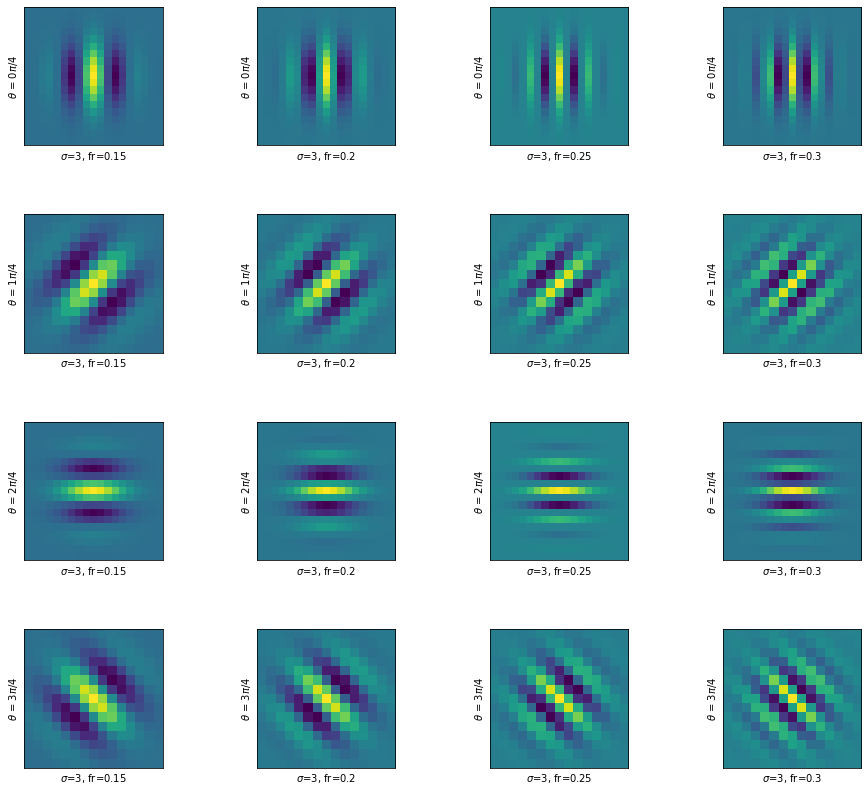

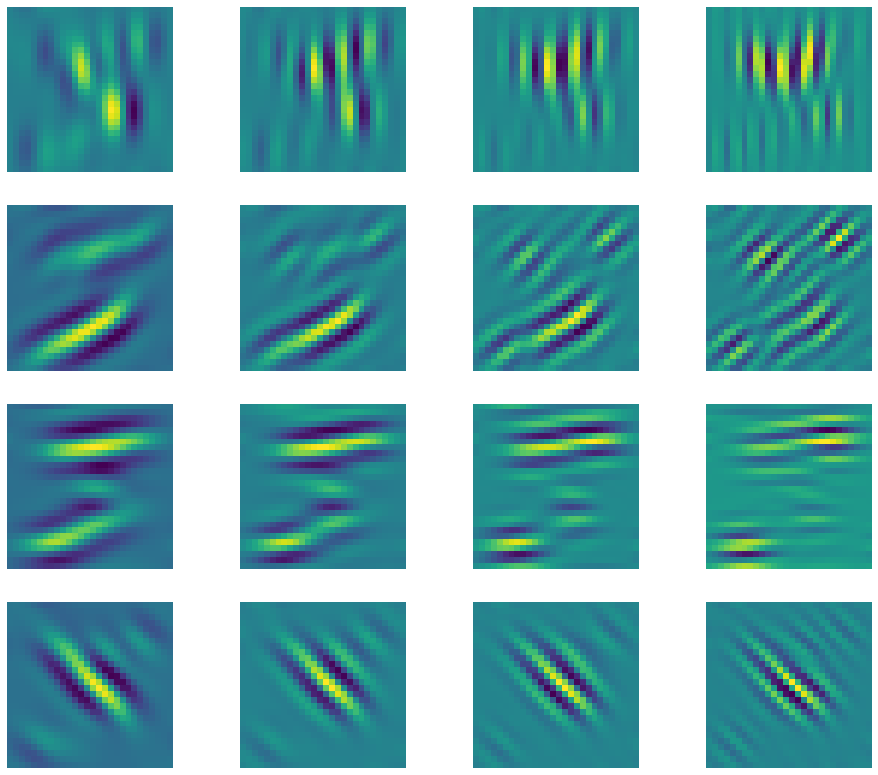

In [3]:
from skimage.filters import gabor_kernel
import numpy as np
from scipy import ndimage as ndi
import cv2
from skimage.measure import block_reduce
from matplotlib import pyplot as plt
#读取数据
data = np.load('mnist.npz')

#定义gabor滤波器
kernels = []
#二维窗函数有效的宽度和高度
sigma = 3
#空间频率
frs = [0.15, 0.2, 0.25, 0.3]
for k in range(4):
    # 方向
    theta = k / 4. * np.pi
    for frequency in frs:
        #滤波器为复数，这里我们只取实部
        kernel = np.real(gabor_kernel(frequency, theta=theta,
                                      sigma_x=sigma, sigma_y=sigma))
        kernels.append(kernel)
        
if __name__ == '__main__':
    #可视化
    i=0

    image = data['train_x'][i]
    f0, axs0 = plt.subplots(4, 4, figsize=(16, 14))
    plt.subplots_adjust(hspace=0.5)
    f, axs = plt.subplots(4, 4, figsize=(16, 14))

    for k, kernel in enumerate(kernels):
        j = k % 4
        #可视化Gabor滤波器
        axs0[k // 4][j].imshow(kernel)
        axs0[k // 4][j].set_xlabel('$\sigma$={}, fr={}'.format(sigma, frs[j]))
        axs0[k // 4][j].set_ylabel('$\\theta$ = {}$\pi$/4'.format(k//4))
        axs0[k // 4][j].set_yticks([])
        axs0[k // 4][j].set_xticks([])
        
        #卷积运算
        filtered = ndi.convolve(image, kernel, mode='wrap')
        #可视化图像滤波后得到的特征
        axs[k // 4][j].imshow(filtered)
        axs[k // 4][j].axis('off')

    plt.show()

## 特征提取
我们利用Gabor滤波器组对`训练样本（60000个）`和`测试样本（10000个）`进行特征提取，分别得到`60000*1024`和`10000*1024`维的特征矩阵。由于图片数量较多，利用Gabor滤波器组提取特征的时间比较长，我们已经将提取好的特征数据文件feat.npz存放在当前目录下。

In [4]:
#通过gabor滤波器组提取图像特征
def compute_feats(image, norm_size=(32, 32), pool=(4, 4), mode='mean', edge=False):
    image = cv2.resize(image, norm_size)
    if edge:
        image = cv2.Canny(image, 85, 255, apertureSize=3, L2gradient=True)  # 边缘提取

    # 计算特征图的宽和高
    h, w = norm_size[1] // pool[0], norm_size[0] // pool[1]
    feats = np.zeros([1, h * w * len(kernels)], dtype=np.double)
    for k, kernel in enumerate(kernels):
        # 卷积滤波
        filtered = ndi.convolve(image, kernel, mode='wrap') 
        # 池化
        filtered = block_reduce(filtered, pool, np.max if mode == 'max' else np.mean)  
        feats[0, k * h * w: (k + 1) * h * w] = filtered.reshape(-1)
    return feats

# 以下代码用于生成feat.npz

# data = np.load('mnist.npz')

# image_train = data['train_x']
# label_train = data['train_y']

# image_test = data['test_x']
# label_test = data['test_y']

# Xtrain=np.zeros([60000, 1024], dtype=np.double)

# for i in range(60000):
#     Xtrain[i, :] = compute_feats(image_train[i]).reshape(-1)

# ytrain=label_train

# Xtest=np.zeros([10000, 1024], dtype=np.double)

# for i in range(10000):
#     Xtest[i, :] = compute_feats(image_test[i]).reshape(-1)

# ytest=label_test


# np.savez('./feat.npz', Xtrain=Xtrain,ytrain=ytrain, Xtest=Xtest,ytest=ytest)

对得到的`feat.npz`文件的读取方法如下：

In [5]:
data = np.load('feat.npz')

print(data.__dict__)
print(data['Xtrain'].shape, data['Xtrain'].dtype)
print(data['ytrain'].shape, data['ytrain'].dtype)
print(data['Xtest'].shape, data['Xtest'].dtype)
print(data['ytest'].shape, data['ytest'].dtype)

{'_files': ['Xtrain.npy', 'ytrain.npy', 'Xtest.npy', 'ytest.npy'], 'files': ['Xtrain', 'ytrain', 'Xtest', 'ytest'], 'allow_pickle': False, 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True}, 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='feat.npz'> mode='r'>, 'f': <numpy.lib.npyio.BagObj object at 0x0000023A9432E308>, 'fid': <_io.BufferedReader name='feat.npz'>}
(60000, 1024) float64
(60000,) uint8
(10000, 1024) float64
(10000,) uint8


## PCA/LDA特征降维及可视化

(500, 2)
(500, 2)
(500,)


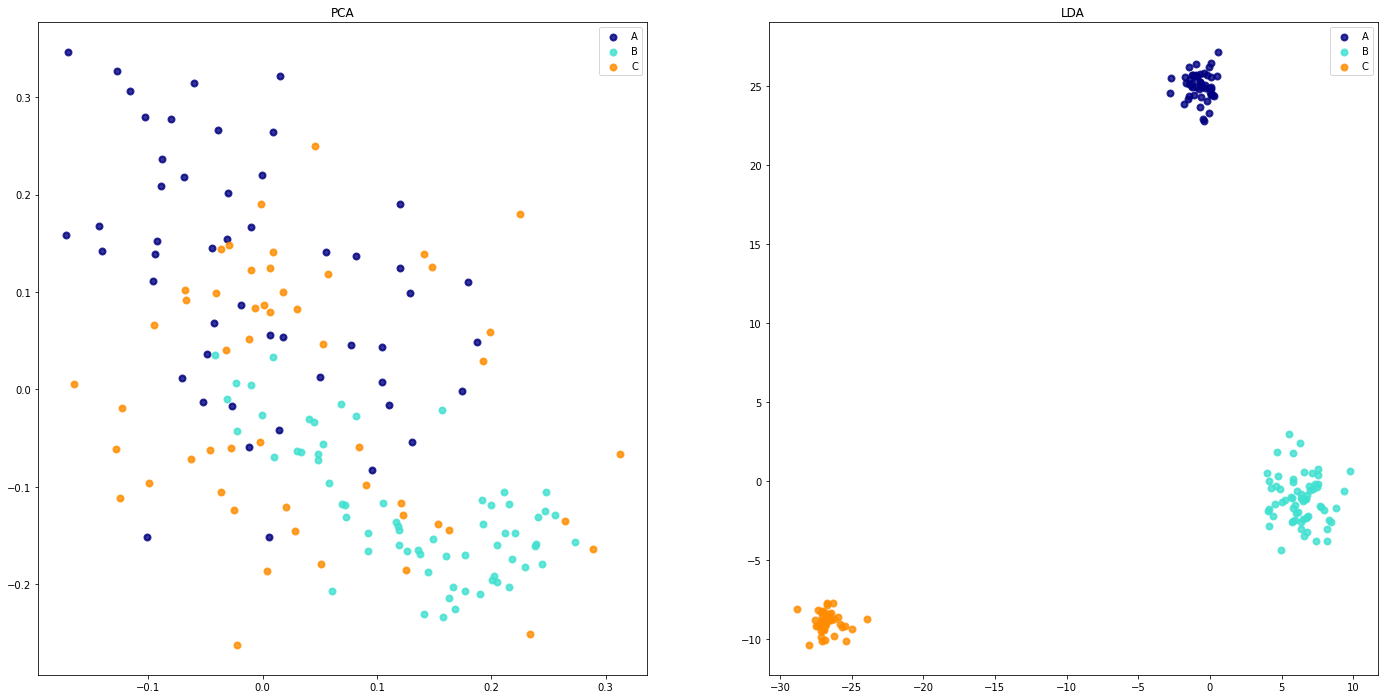

In [6]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#定义PCA
class PCAredu():
    def __init__(self, n_components, X):
        # 初始化PCA，n_components为降维后特征维度
        self.pca = PCA(n_components=n_components)
        # 计算降维所需的特征向量
        self.pca.fit(X)

    def redu(self, X):
        # 返回降维后的特征
        return self.pca.transform(X)

#定义LDA
class LDAredu():
    def __init__(self, n_components, X, y):
        # 初始化LDA，n_components为降维后特征维度
        self.lda = LDA(n_components=n_components)
        self.lda.fit(X, y)

    def redu(self, X):
        # 返回降维后的特征
        return self.lda.transform(X)

#可视化函数
def visual(X_pca, X_lda, y):
    # X_pca, X_lda: [n, 2] 
    # y: [n]

    colors = ['navy', 'turquoise', 'darkorange']
    target_names = ['A', 'B', 'C']

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        # 画散点图
        ax1.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, alpha=.8, lw=2,
                    label=target_name)
        ax2.scatter(X_lda[y == i, 0], X_lda[y == i, 1], color=color, alpha=.8, lw=2,
                    label=target_name)
    ax1.legend(loc='best', shadow=False, scatterpoints=1)
    ax1.set_title('PCA')
    ax2.legend(loc='best', shadow=False, scatterpoints=1)
    ax2.set_title('LDA')
    plt.show()


def main_dimRedu(ndim=2):
    data = np.load('feat.npz')

    #取500个样本用于可视化
    Xtrain, ytrain = data['Xtrain'][:500,], data['ytrain'][:500,]

    pca = PCAredu(ndim, Xtrain)
    lda = LDAredu(ndim, Xtrain, ytrain)
    Xtrain_pca = pca.redu(Xtrain)
    Xtrain_lda = lda.redu(Xtrain)
    
    print(Xtrain_pca.shape)
    print(Xtrain_lda.shape)
    print(ytrain.shape)

    visual(Xtrain_pca, Xtrain_lda, ytrain)

if __name__ == '__main__':
    main_dimRedu(ndim=2)

## 直接利用原始Gabor特征进行分类

1. 分类器采用线性判别函数(Linear Discriminant Function, LDF)

In [10]:
from classifier import build_QDF_model, QDF_predict, build_LDF_model, LDF_predict, build_MQDF_model, MQDF_predict
data = np.load('feat.npz')

Xtrain, ytrain = data['Xtrain'], data['ytrain']
Xtest, ytest=data['Xtest'], data['ytest']

inverse_cov, weight, w0 = build_LDF_model(10, Xtrain, ytrain)
ypred = LDF_predict(Xtrain, 10, inverse_cov, weight, w0)

num_correct = (ypred == ytrain).sum()

print('The accuracy of LDF classifier on the training set: %.4f'%(num_correct/60000))

ypred = LDF_predict(Xtest, 10, inverse_cov, weight, w0)

num_correct = (ypred == ytest).sum()

print('The accuracy of LDF classifier on the test set: %.4f'%(num_correct/10000))

The accuracy of LDF classifier on the training set: 0.8734
The accuracy of LDF classifier on the test set: 0.8755


2. 分类器采用二次判别函数(Quadratic Discriminant Function, QDF)

In [11]:
prior, mean, cov_matrix = build_QDF_model(10, Xtrain, ytrain)
ypred = QDF_predict(Xtrain, 10, prior, mean, cov_matrix)

num_correct = (ypred == ytrain).sum()

print('The accuracy of QDF classifier on the training set: %.4f'%(num_correct/60000))

ypred = QDF_predict(Xtest, 10, prior, mean, cov_matrix)

num_correct = (ypred == ytest).sum()

print('The accuracy of QDF classifier on the test set: %.4f'%(num_correct/10000))

The accuracy of QDF classifier on the training set: 0.1579
The accuracy of QDF classifier on the test set: 0.1621


3. 分类器采用修正二次判别函数(Modified Quadratic Discriminant Function, MQDF)

In [12]:
prior, mean, eigenvalue, eigenvector, delta = build_MQDF_model(10, Xtrain, ytrain, k=20, delta0=0)
ypred = MQDF_predict(Xtrain, 10, 20, mean, eigenvalue, eigenvector, delta)

num_correct = (ypred == ytrain).sum()

print('The accuracy of MQDF classifier on the training set: %.4f'%(num_correct/60000))

ypred = MQDF_predict(Xtest, 10, 20, mean, eigenvalue, eigenvector, delta)

num_correct = (ypred == ytest).sum()

print('The accuracy of MQDF classifier on the test set: %.4f'%(num_correct/10000))

The accuracy of MQDF classifier on the training set: 0.9402
The accuracy of MQDF classifier on the test set: 0.9394


## 利用PCA降维的特征进行分类

利用PCA对Gabor特征降维：

In [30]:
data = np.load('feat.npz')

Xtrain, ytrain = data['Xtrain'], data['ytrain']
Xtest,ytest=data['Xtest'], data['ytest']

#降维后的特征维度
ndim=40

pca = PCAredu(ndim, Xtrain)

Xtrain_pca = pca.redu(Xtrain)
Xtest_pca = pca.redu(Xtest)

1. 分类器采用线性判别函数(Linear Discriminant Function, LDF)

In [31]:
inverse_cov, weight, w0 = build_LDF_model(10, Xtrain_pca, ytrain)
ypred = LDF_predict(Xtrain_pca, 10, inverse_cov, weight, w0)

num_correct = (ypred == ytrain).sum()

print('The accuracy of LDF classifier on the training set: %.4f'%(num_correct/60000))

ypred = LDF_predict(Xtest_pca, 10, inverse_cov, weight, w0)

num_correct = (ypred == ytest).sum()

print('The accuracy of LDF classifier on the test set: %.4f'%(num_correct/10000))

The accuracy of LDF classifier on the training set: 0.8405
The accuracy of LDF classifier on the test set: 0.8536


2. 分类器采用二次判别函数(Quadratic Discriminant Function, QDF)

In [32]:
prior, mean, cov_matrix = build_QDF_model(10, Xtrain_pca, ytrain)
ypred = QDF_predict(Xtrain_pca, 10, prior, mean, cov_matrix)

num_correct = (ypred == ytrain).sum()

print('The accuracy of QDF classifier on the training set: %.4f'%(num_correct/60000))

ypred = QDF_predict(Xtest_pca, 10, prior, mean, cov_matrix)

num_correct = (ypred == ytest).sum()

print('The accuracy of QDF classifier on the test set: %.4f'%(num_correct/10000))

The accuracy of QDF classifier on the training set: 0.9515
The accuracy of QDF classifier on the test set: 0.9521


3. 分类器采用修正二次判别函数(Modified Quadratic Discriminant Function, MQDF)

In [33]:
prior, mean, eigenvalue, eigenvector, delta = build_MQDF_model(10, Xtrain_pca, ytrain, k=20, delta0=0)
ypred = MQDF_predict(Xtrain_pca, 10, 20, mean, eigenvalue, eigenvector, delta)

num_correct = (ypred == ytrain).sum()

print('The accuracy of MQDF classifier on the training set: %.4f'%(num_correct/60000))

ypred = MQDF_predict(Xtest_pca, 10, 20, mean, eigenvalue, eigenvector, delta)

num_correct = (ypred == ytest).sum()

print('The accuracy of MQDF classifier on the test set: %.4f'%(num_correct/10000))

The accuracy of MQDF classifier on the training set: 0.9451
The accuracy of MQDF classifier on the test set: 0.9440


## 利用LDA降维的特征进行分类

利用LDA对Gabor特征降维：

In [7]:
data = np.load('feat.npz')

Xtrain, ytrain = data['Xtrain'], data['ytrain']
Xtest,ytest=data['Xtest'], data['ytest']

#降维后的特征维度
ndim=8

lda = LDAredu(ndim, Xtrain, ytrain)

Xtrain_lda = lda.redu(Xtrain)
Xtest_lda = lda.redu(Xtest)

1. 分类器采用线性判别函数(Linear Discriminant Function, LDF)

In [18]:
inverse_cov, weight, w0 = build_LDF_model(10, Xtrain_lda, ytrain)
ypred = LDF_predict(Xtrain_lda, 10, inverse_cov, weight, w0)

num_correct = (ypred == ytrain).sum()

print('The accuracy of LDF classifier on the training set: %.4f'%(num_correct/60000))

ypred = LDF_predict(Xtest_lda, 10, inverse_cov, weight, w0)

num_correct = (ypred == ytest).sum()

print('The accuracy of LDF classifier on the test set: %.4f'%(num_correct/10000))

The accuracy of LDF classifier on the training set: 0.8701
The accuracy of LDF classifier on the test set: 0.8715


2. 分类器采用二次判别函数(Quadratic Discriminant Function, QDF)

In [19]:
prior, mean, cov_matrix = build_QDF_model(10, Xtrain_lda, ytrain)
ypred = QDF_predict(Xtrain_lda, 10, prior, mean, cov_matrix)

num_correct = (ypred == ytrain).sum()

print('The accuracy of QDF classifier on the training set: %.4f'%(num_correct/60000))

ypred = QDF_predict(Xtest_lda, 10, prior, mean, cov_matrix)

num_correct = (ypred == ytest).sum()

print('The accuracy of QDF classifier on the test set: %.4f'%(num_correct/10000))

The accuracy of QDF classifier on the training set: 0.8908
The accuracy of QDF classifier on the test set: 0.8941


3. 分类器采用修正二次判别函数(Modified Quadratic Discriminant Function, MQDF)

In [20]:
prior, mean, eigenvalue, eigenvector, delta = build_MQDF_model(10, Xtrain_lda, ytrain, k=7, delta0=0)
ypred = MQDF_predict(Xtrain_lda, 10, 7, mean, eigenvalue, eigenvector, delta)

num_correct = (ypred == ytrain).sum()

print('The accuracy of MQDF classifier on the training set: %.4f'%(num_correct/60000))

ypred = MQDF_predict(Xtest_lda, 10, 7, mean, eigenvalue, eigenvector, delta)

num_correct = (ypred == ytest).sum()

print('The accuracy of MQDF classifier on the test set: %.4f'%(num_correct/10000))

The accuracy of MQDF classifier on the training set: 0.8907
The accuracy of MQDF classifier on the test set: 0.8941


除了上述分类器外，我们还可以尝试支持向量机，本教程使用Scikit-Learn机器学习库中的SVM分类器。

使用SVM分类器进行训练，并测试其准确率的程序如下。

In [8]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(Xtrain_lda, ytrain)

preds_train = clf.predict(Xtrain_lda)
preds_test = clf.predict(Xtest_lda)

acc_train = sum(np.array(preds_train) == np.array(ytrain)) / len(preds_train)
acc_test = sum(np.array(preds_test) == np.array(ytest)) / len(preds_test)

print('The accuracy of SVM classifier on the training set: %.4f'%(acc_train))
print('The accuracy of SVM classifier on the test set: %.4f'%(acc_test))

The accuracy of SVM classifier on the training set: 0.9186
The accuracy of SVM classifier on the test set: 0.9135


最后，对本教程进行如下总结。

- PCA和LDA的比较：PCA可以用于无监督地对特征进行降维，LDA则利用了标签信息，因此降维后能得到更好的聚类效果。

- LDF, QDF和MQDF的比较：QDF和MQDF往往能获得超过LDF的效果，但当特征中包含较多噪声时，QDF可能无法取得理想的性能。MQDF通常是一个较好的选择。

- 使用SVM也能够取得较高的分类性能。当训练数据足够时，深度神经网络通常能取得最好的性能。